In [1]:
file_path = "../../../testdata/test2.nd2"
output_dir = "../../../testdata/test2_output"
metadata_path : str = "../../../testdata/test2_output/test2_metadata.yaml"
profile_filename = "shading_profile.zarr"

strategy = "timewise" 
robust = False
num_cpus=10

In [2]:
assert strategy in ["timewise"], "strategy must be 'timewise'"

In [3]:
from pathlib import Path

def to_path(x):
    return Path(x).absolute()

_file_path = to_path(file_path)
_output_dir = to_path(output_dir)
_metadata_path = to_path(metadata_path)

In [4]:
import ray
ray.init(num_cpus=num_cpus)

/home/fukai/.pyenv/versions/miniforge3-latest/envs/microflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-20 14:43:30,131	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-20 14:43:33,103	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.13', ray_version='2.9.0', ray_commit='{{RAY_COMMIT_SHA}}', protocol_version=None)

# Import packages and define functions

In [5]:
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
import numpy as np
from dask import array as da
import re
import zarr
import yaml
from skimage import transform, filters, morphology
from utils import read_mosaic_image, show_ray_progress, open_zarr_with_synchronizer
from common import estimate_median_profile
from zarr import Zstd

In [6]:
metadata = yaml.safe_load(Path(_metadata_path).read_text())
channel_names = metadata["channel_names"]
mosaic_dim = metadata["mosaic_dim"]
print(channel_names, mosaic_dim)

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'] scene


# Shading correction

## Open images 

In [7]:
aics_image = AICSImage(_file_path,reconstruct_mosaic=False) 
image = read_mosaic_image(aics_image, mosaic_dim, "TCZYX")

In [8]:
image.shape # (M, T, C, Z, Y, X)

(48, 2, 4, 1, 2296, 2656)

## Output files

In [9]:
profile_path = _output_dir/profile_filename
profile_zarr = open_zarr_with_synchronizer(profile_path,
                         shape=[1]+list(image.shape[1:]),#TCZYX
                         dtype=np.float32,
                         #compressor=Zstd(level=2)
                         )

# Estimate shading

In [10]:
@ray.remote
def process_image(profile_zarr, image, t, c):
    profile_zarr[0,t,c, ... ] = estimate_median_profile(image[:,t,c,...], 0, robust=robust, keepdims=False)
ress = []
for t, c in np.ndindex(image.shape[1:3]):
    ress.append(process_image.remote(profile_zarr, image, t, c))
show_ray_progress(ress)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:49<00:00,  6.25s/it]


[None, None, None, None, None, None, None, None]

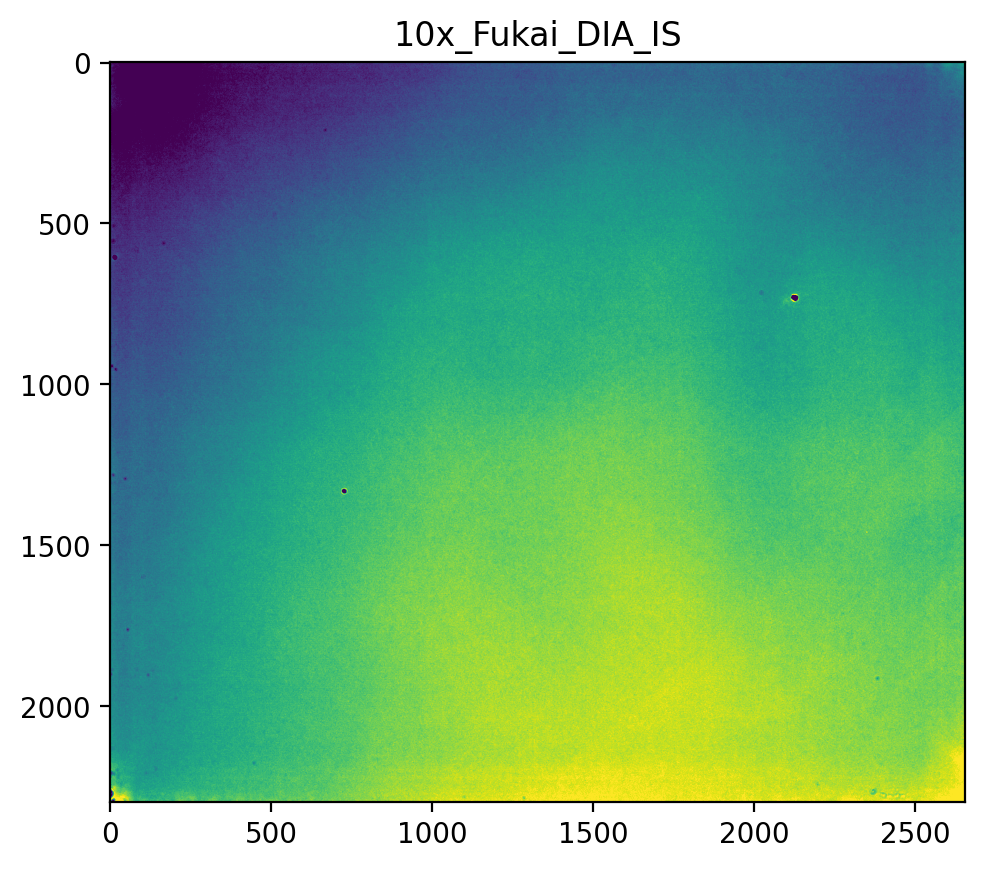

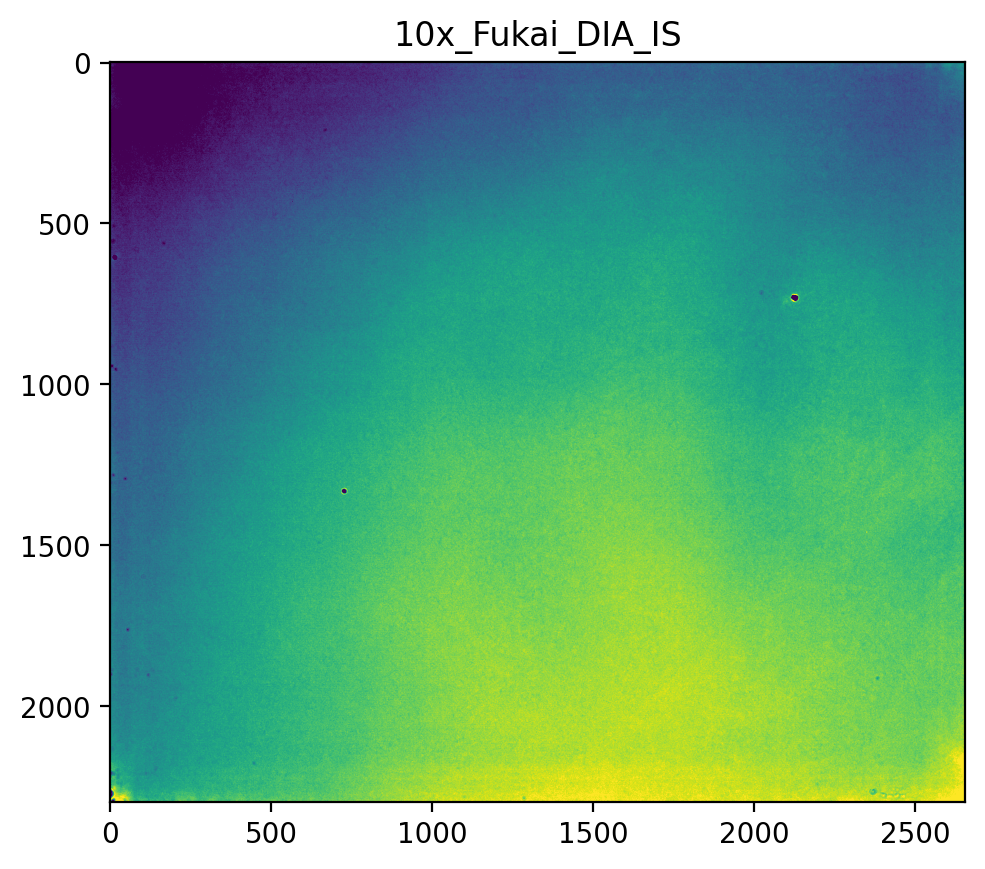

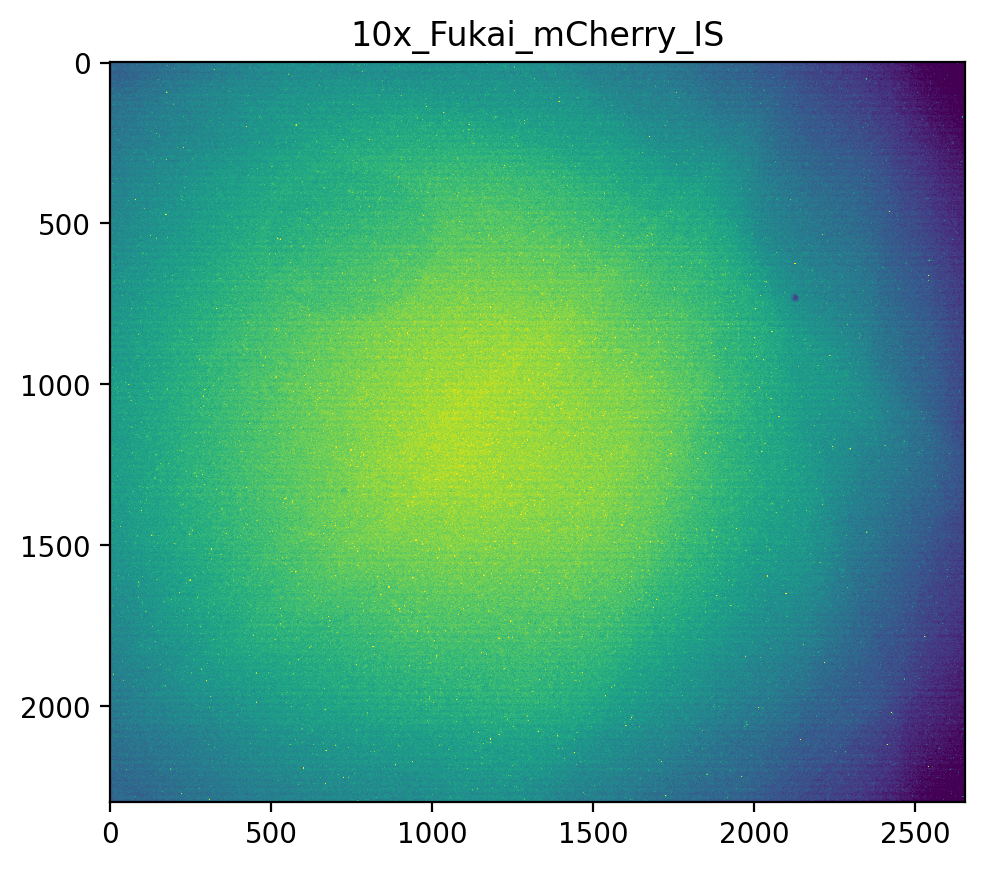

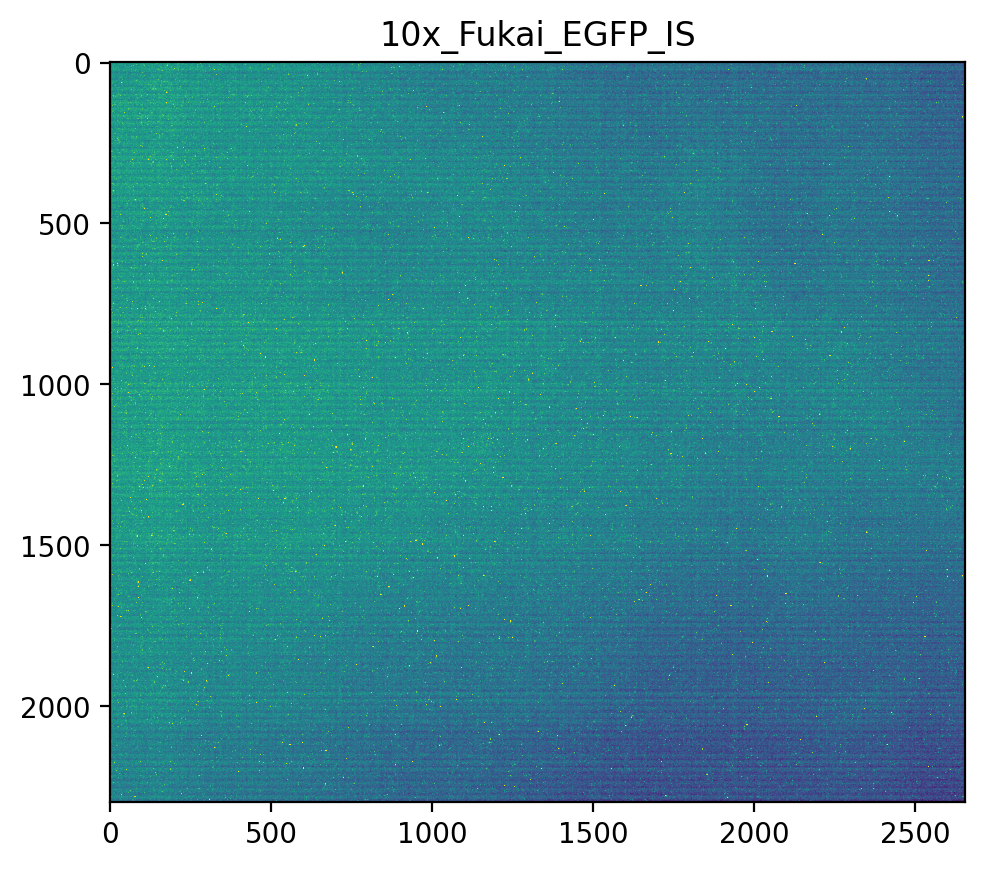

In [11]:
channel_names = channel_names
for j, Cn in enumerate(channel_names):
    m, M = np.percentile(profile_zarr[0,0,j], (1, 99))
    plt.imshow(profile_zarr[0,0,j,0], vmin=m, vmax=M)
    plt.title(Cn)
    plt.show()